# DU-PSOR法の例(ヤコビ法)

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

## 準備(グローバル定数の設定)

In [2]:
n = 32
num_itr = 20
K = 100
max_inner = 50
train_depth = 20
adam_lr = 0.01
M = 0.05randn(n,n)
P = 0.15I + M'*M;

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    q = randn(n, K)
    x_sol = zeros(n, K)
    for j in 1:K
        x_sol[:,j] = P\q[:,j]
    end
    return q, x_sol
end

mini_batch (generic function with 1 method)

### オリジナルのヤコビ法

In [4]:
function Jacobi_itr(max_itr, q)
    x = zeros(n, K)
    D = diagm(diag(P))
    Dinv = inv(D)
    A = -Dinv * (P - D)
    b = Dinv*q
    for i in 1:max_itr
        x = A*x + b
    end
    return x
end

Jacobi_itr (generic function with 1 method)

In [5]:
function comp_mse(max_itr)
    se = 0.0
    q, x_sol = mini_batch(K)
    x̂ = Jacobi_itr(max_itr, q)
    return norm(x̂ - x_sol)^2/K
end

comp_mse (generic function with 1 method)

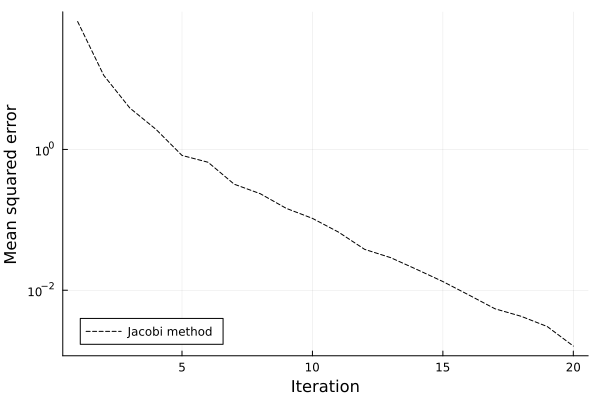

In [6]:
Jacobi_mse = [comp_mse(i) for i in 1:num_itr];
plot(1:num_itr, Jacobi_mse, lw=1, yscale=:log10, label="Jacobi method", color=:black, ls=:dash, xlabel="Iteration", ylabel="Mean squared error", legend=:bottomleft)

### DU-PSOR反復の定義 

In [7]:
function DU_PSOR(q, max_itr, ω, T)
    x = zeros(n, K)
    D = diagm(diag(P))
    Dinv = inv(D)
    A = -Dinv * (P - D)
    b = Dinv*q
    for i in 0:max_itr-1
        k = (i % T)+1 
        x = x + ω[k]*(A*x+b - x)
    end
    return x
end

DU_PSOR (generic function with 1 method)

### 損失関数の定義

In [8]:
function loss(x_fixed, x̂)
    return norm(x_fixed - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [9]:
function train(opt, ω, T)
    ps = Flux.params(ω)
    for itr in 1:train_depth
        for i in 1:max_inner 
            q, x_sol = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_hat = DU_PSOR(q, itr, ω, T)
                loss(x_sol, x_hat)
            end
            Flux.Optimise.update!(opt, ps, gs) 
        end
        q, x_sol = mini_batch(K)
        x̂ = DU_PSOR(q, itr, ω, T)
        println(loss(x_sol, x̂))
    end
end

train (generic function with 1 method)

In [10]:
function comp_mse_DUPSOR(max_itr, ω, T)
    q, x_sol = mini_batch(K)
    x̂ = DU_PSOR(q, max_itr, ω, T)
    return loss(x_sol, x̂)
end

comp_mse_DUPSOR (generic function with 1 method)

### 学習過程

58.88592905204855
10.80233642878337
2.1061575704635955
0.46474997285182157
0.10075643731122674
0.022397434659464876
0.004929085981303238
0.0012727780787192122
0.0004162650640554195
0.00012128724122358357
3.7444466295906106e-5
1.3157795659670971e-5
4.3304997364200514e-6
1.365356379046435e-6
4.022642883752432e-7
1.3359918212179945e-7
4.524748655711977e-8
1.8690225299818607e-8
4.490573130599046e-9
1.867184468678741e-9


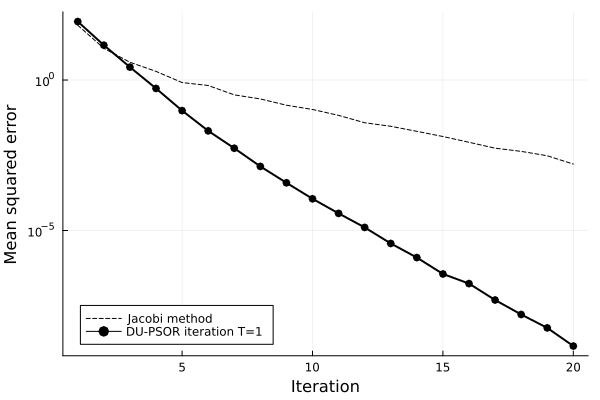

In [11]:
T = 1
ω_train = ones(T)
opt = Flux.ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:o)

59.619981672240286
4.699405349558019
0.6490166630170612
0.07761611105139142
0.010345602526146936
0.0012844819806714953
0.00017654849902913052
2.1206862534429768e-5
2.553518261015595e-6
3.5229555721272896e-7
4.648027024986047e-8
6.103585628049838e-9
8.894923322756602e-10
1.173127503458512e-10
1.7378275394011272e-11
2.0568372316778953e-12
3.032142710179767e-13
3.896969058806574e-14
5.087145356881238e-15
7.064278433550123e-16


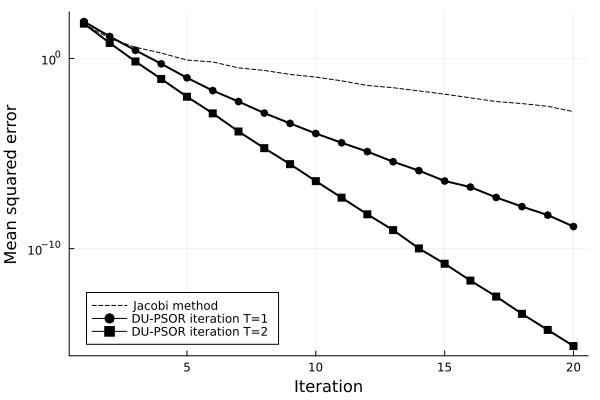

In [12]:
T = 2
ω_train = ones(T)
opt = Flux.ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:rect)

58.011346931141176
5.117762718577962
0.36329771723349935
0.05338577468439309
0.0038532857763167528
0.00019791548624654198
1.383195117727136e-5
1.4227495874843228e-6
2.1042200054253064e-7
1.4998725865835526e-8
1.2773048013660327e-9
3.438249987480199e-10
1.8176193223229967e-11
9.657290636915143e-13
9.81348391208562e-14
1.2566357139249713e-14
2.6086596077469136e-15
8.05495789258787e-17
1.1810387601943408e-17
2.7435806323244485e-18


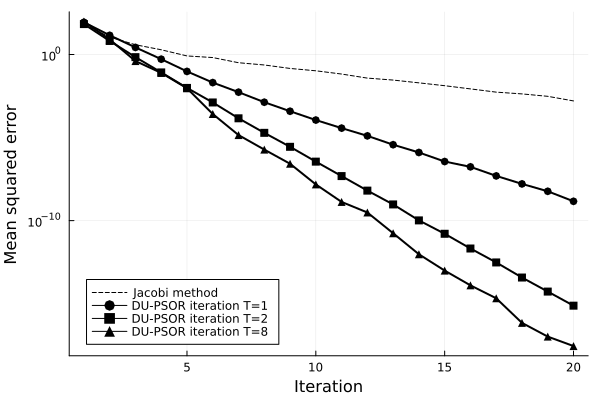

In [13]:
T = 8
ω_train = ones(T)
opt = Flux.ADAM(adam_lr)
train(opt, ω_train, T)
DUPSOR_mse =[comp_mse_DUPSOR(i, ω_train, T) for i in 1:num_itr]
plot!(1:num_itr, DUPSOR_mse, lw=2, label="DU-PSOR iteration T="*string(T), color=:black, marker=:utriangle)

In [14]:
savefig("DU-PSOR-Jacobi.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_4/DU-PSOR-Jacobi.pdf"